<a href="https://colab.research.google.com/github/gustianaditama/vgsales/blob/main/video_game_sales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install petl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.6/409.6 kB 13.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for petl: filename=petl-1.7.12-py3-none-any.whl size=226951 sha256=270a4499fb743204b68c7713188418cf0c070e00b3b5191e82ff696834b895aa
  Stored in directory: /root/.cache/pip/wheels/17/a2/7a/68707dd0e3b3ce2a2acfcec8e16eb8464018a4a57eca1fd8fb
Successfully built petl


In [ ]:
import pandas as pd
import numpy as np
import petl as etl
import sqlite3

In [ ]:
engine = sqlite3.connect('vg_sales.db')
data = pd.DataFrame(engine.execute("SELECT * FROM sales"), columns=['Rank', 'Platform', 'NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales'])
data = data[['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales', 'Platform']]
data.to_csv('vgsales.csv')

# EDA

In [ ]:
import seaborn as sns

In [ ]:
data.describe()

,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
count,16598.000000,16598.000000,16598.000000,16598.000000,16598.000000
mean,0.264667,0.146652,0.077782,0.048063,0.537441
std,0.816683,0.505351,0.309291,0.188588,1.555028
min,0.000000,0.000000,0.000000,0.000000,0.010000
25%,0.000000,0.000000,0.000000,0.000000,0.060000
50%,0.080000,0.020000,0.000000,0.010000,0.170000
75%,0.240000,0.110000,0.040000,0.040000,0.470000
max,41.490000,29.020000,10.220000,10.570000,82.740000


<Axes: xlabel='Platform', ylabel='count'>

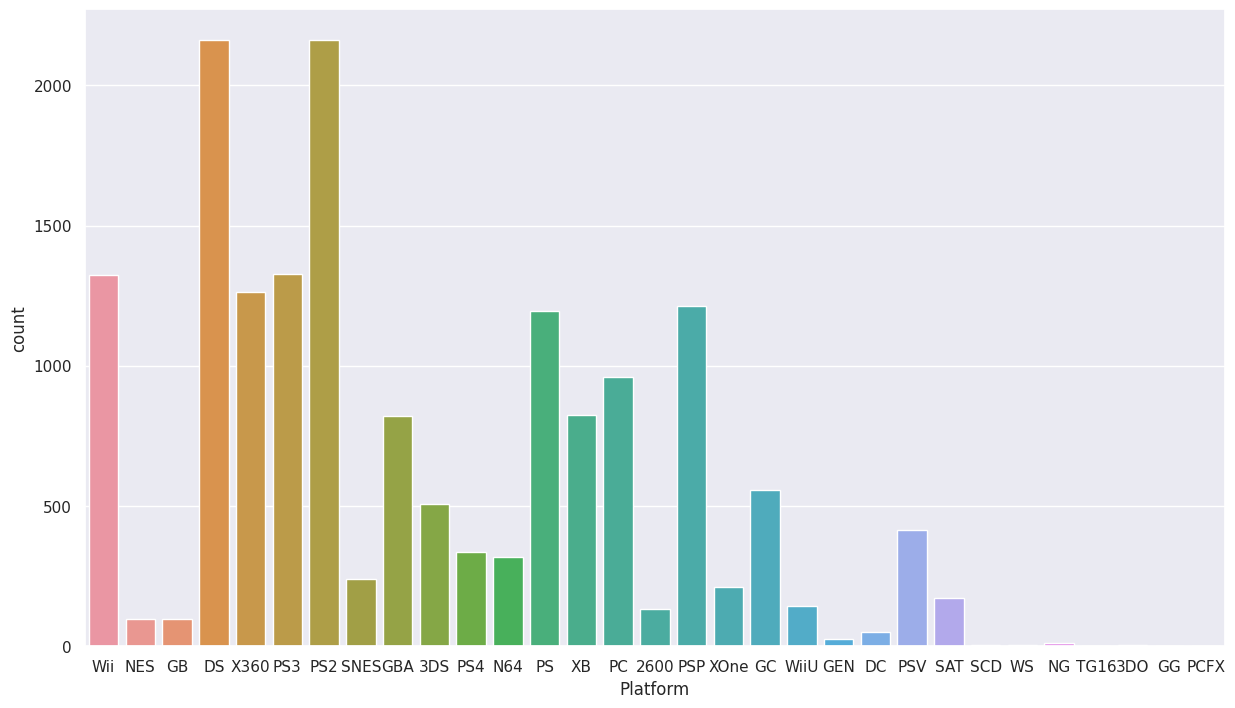

In [ ]:
sns.set(rc={'figure.figsize':(14.7,8.27)})
sns.countplot(x='Platform',data=data)

  sns.heatmap(data.corr(), cmap='Blues', annot = True);



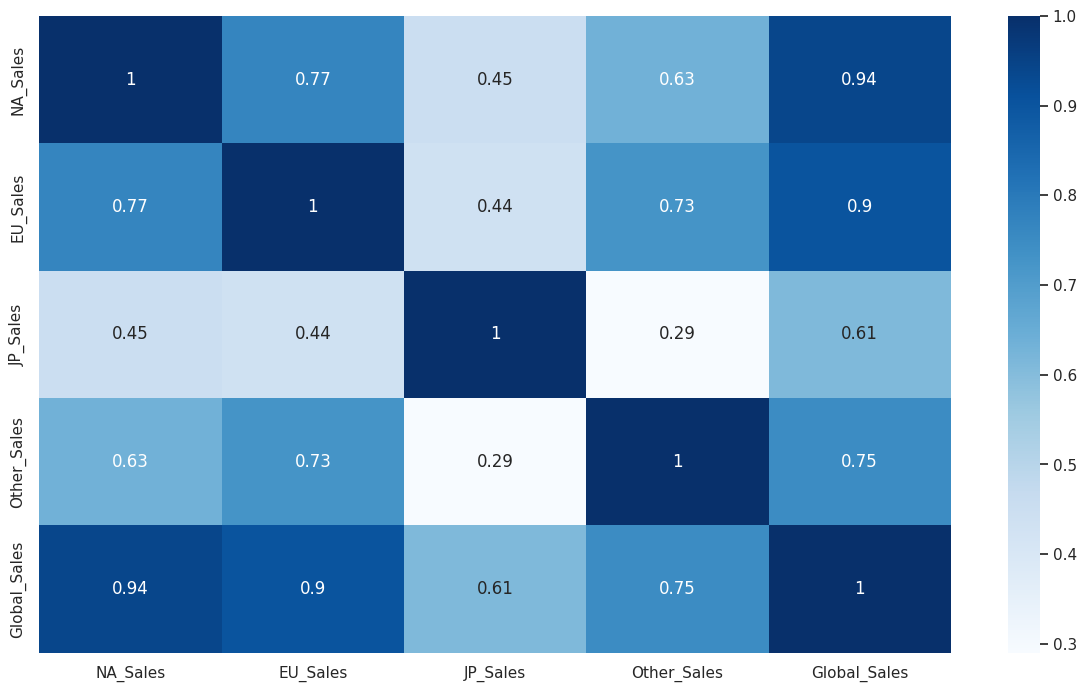

In [ ]:
sns.heatmap(data.corr(), cmap='Blues', annot = True);

In [ ]:
data['Platform'].unique()

array(['Wii', 'NES', 'GB', 'DS', 'X360', 'PS3', 'PS2', 'SNES', 'GBA',
       '3DS', 'PS4', 'N64', 'PS', 'XB', 'PC', '2600', 'PSP', 'XOne', 'GC',
       'WiiU', 'GEN', 'DC', 'PSV', 'SAT', 'SCD', 'WS', 'NG', 'TG16',
       '3DO', 'GG', 'PCFX'], dtype=object)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16598 entries, 0 to 16597
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   NA_Sales      16598 non-null  float64
 1   EU_Sales      16598 non-null  float64
 2   JP_Sales      16598 non-null  float64
 3   Other_Sales   16598 non-null  float64
 4   Global_Sales  16598 non-null  float64
 5   Platform      16598 non-null  object 
dtypes: float64(5), object(1)
memory usage: 778.2+ KB


In [ ]:
def outlier_index(data):
  Q1 = data.quantile(0.25)
  Q3 = data.quantile(0.75)
  IQR = Q3 - Q1
  out = (data < (Q1 - 1.5 * IQR) | (data > (Q3 + 1.5 * IQR)))
  out = out.loc[(out['NA_Sales'] == True) & (out['EU_Sales'] == True) & (out['JP_Sales'] == True) & (out['Other_Sales'] == True) & (out['Global_Sales'] == True)].index
  return out

outlier_index(data[['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales']])

Int64Index([ 2081,  2082,  2083,  2084,  2085,  2086,  2087,  2088,  2089,
             2090,
            ...
            16588, 16589, 16590, 16591, 16592, 16593, 16594, 16595, 16596,
            16597],
           dtype='int64', length=14517)

# Cleaning

### Z-score

In [ ]:
def zscore(data):
  list_fitur = data.columns[:-1]
  for fitur in list_fitur:
    mean = data[fitur].mean()
    stdev = data[fitur].std()
    data[fitur] = (data[fitur]-mean)/stdev
  return data

data_normalized = zscore(data)
data_normalized

,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Platform
0,50.478988,57.135209,11.937698,44.604742,52.862433,Wii
1,35.283374,6.793984,21.766640,3.828109,25.531734,NES
2,19.083698,25.197026,12.002362,17.296594,22.689341,Wii
3,18.961252,21.496629,10.353428,15.440700,20.875869,Wii
4,13.475647,17.301527,32.791869,5.047696,19.827656,GB
...,...,...,...,...,...,...
16593,-0.311831,-0.290198,-0.251484,-0.254857,-0.339184,GBA
16594,-0.311831,-0.290198,-0.251484,-0.254857,-0.339184,GC
16595,-0.324076,-0.290198,-0.251484,-0.254857,-0.339184,PS2
16596,-0.324076,-0.270410,-0.251484,-0.254857,-0.339184,DS


### Deleting Outlier

In [ ]:
outlier_index(data_normalized[['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales']])

Int64Index([  790,   851,   889,   919,   939,   941,   958,   963,   970,
              978,
            ...
            16588, 16589, 16590, 16591, 16592, 16593, 16594, 16595, 16596,
            16597],
           dtype='int64', length=14825)

In [ ]:
data_no_out = data.drop(outlier_index(data_normalized[['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales']]))
data_no_out

,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Platform
0,50.478988,57.135209,11.937698,44.604742,52.862433,Wii
1,35.283374,6.793984,21.766640,3.828109,25.531734,NES
2,19.083698,25.197026,12.002362,17.296594,22.689341,Wii
3,18.961252,21.496629,10.353428,15.440700,20.875869,Wii
4,13.475647,17.301527,32.791869,5.047696,19.827656,GB
...,...,...,...,...,...,...
5006,-0.201630,-0.290198,-0.251484,1.229858,-0.101246,PS2
5059,-0.177140,-0.290198,-0.251484,1.123807,-0.101246,PS2
5374,-0.238364,-0.230834,-0.251484,1.070782,-0.126969,PS2
5675,-0.287342,-0.290198,-0.251484,1.229858,-0.139831,PS2


# Modelling (KNN)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [ ]:
X = data_no_out[['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales']]
Y = data_no_out['Platform']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 0)

In [ ]:
classifier = KNeighborsClassifier(n_neighbors = 3)
classifier.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

In [ ]:
y_pred = classifier.predict(X_test)

In [ ]:
cm = classification_report(y_test, y_pred)
print(cm)

  _warn_prf(average, modifier, msg_start, len(result))

  _warn_prf(average, modifier, msg_start, len(result))

  _warn_prf(average, modifier, msg_start, len(result))



              precision    recall  f1-score   support

        2600       0.20      0.33      0.25         3
         3DS       0.18      0.50      0.26        10
          DC       0.00      0.00      0.00         2
          DS       0.20      0.32      0.24        28
          GB       0.26      0.33      0.29        15
         GBA       0.20      0.25      0.22        12
          GC       0.17      0.11      0.13         9
         GEN       0.00      0.00      0.00         1
         N64       0.33      0.33      0.33         6
         NES       0.36      0.21      0.26        24
          PC       0.23      0.33      0.27         9
          PS       0.58      0.59      0.58        32
         PS2       0.59      0.57      0.58        60
         PS3       0.52      0.46      0.48        35
         PS4       0.17      0.20      0.18        10
         PSP       0.80      0.36      0.50        11
         PSV       0.00      0.00      0.00         3
         SAT       0.00    

# Dashboard

In [ ]:
! pip install streamlit -q

In [ ]:
%%writefile app.py
import streamlit as st
import pandas as pd

data = pd.read_csv('vgsales.csv')
data = data[['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales', 'Platform']]

st.title('Projek Akhir Data Engineering\nKelompok 34')

#Describe data
st.header("1. Informasi statistikal data berdasarkan daerah")
region = ['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales']
selected_region = st.selectbox('Daerah', region)
st.write(data.describe()[selected_region])

#Showing all labels
st.header("2. Daftar kelas yang dimiliki (Platform)")
st.write(data['Platform'].unique())

#Showing number of row for each labels
st.header("3. Banyaknya baris data yang dimiliki setiap label")
st.image("LabelCount.png")
st.write("Platform DS memiliki data yang paling banyak dan diikuti platform PS2 dengan perbedaan yang kecil")

#Showing heat Map
st.header("4. Hubungan antara satu kolom dengan kolom lain")
st.image("CorrMap.png")
st.write("Hubungan antara NA_Sales dengan Global_Sales adalah yang paling kuat")


#Normalized with Z-score
st.header("5. Normalisasi menggunakan Z-score")
def zscore(data):
  list_fitur = data.columns[:-1]
  for fitur in list_fitur:
    mean = data[fitur].mean()
    stdev = data[fitur].std()
    data[fitur] = (data[fitur]-mean)/stdev
  return data

data_normalized = zscore(data)
st.write("Data setelah dinormalisasi")
st.write(data_normalized)

#Deleting outlier
st.header("6. Menghapus data outlier\nDihapus apabila semua kolom dalam satu baris adalah outlier")
def outlier_index(data):
  Q1 = data.quantile(0.25)
  Q3 = data.quantile(0.75)
  IQR = Q3 - Q1
  out = (data < (Q1 - 1.5 * IQR) | (data > (Q3 + 1.5 * IQR)))
  out = out.loc[(out['NA_Sales'] == True) & (out['EU_Sales'] == True) & (out['JP_Sales'] == True) & (out['Other_Sales'] == True) & (out['Global_Sales'] == True)].index
  return out

data_no_out = data.drop(outlier_index(data_normalized[['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales']]))
st.write("Data tanpa outlier :")
st.write(data_no_out)

#Modelling
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

X = data_no_out[['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales']]
Y = data_no_out['Platform']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3, random_state = 0)

classifier = KNeighborsClassifier(n_neighbors = 3)
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)
cm = classification_report(y_test, y_pred)

st.header("7. Melakukan pelatihan menggunakan algoritma KNN")
st.write("Data Latih :")
st.write(X_train)
st.write("\nData Uji :")
st.write(X_test)
st.write("\nHasil Prediksi :")
st.image("ClassificationReport.png")

Overwriting app.py


In [ ]:
!streamlit run app.py & npx localtunnel --port 8501

[##................] - fetchMetadata: sill resolveWithNewModule ms@2.1.2 checki


  You can now view your Streamlit app in your browser.

  Network URL: http://172.28.0.12:8501
  External URL: http://34.90.148.146:8501

npx: installed 22 in 2.755s
your url is: https://empty-guests-stand.loca.lt
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: